In [1]:
###Import Packages###
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from skimage import io, color

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision
# import vtk
# from vedo import *

In [83]:
# !rm -rf /content/data

In [84]:
!mkdir data/

In [ ]:
###Unzip DATA###

#Before run the code section, manually upload data to the file space / work space
!unzip /content/original_img.zip -d /content/data/
!unzip /content/masked_img.zip -d /content/data/
os.rename('/content/data/Images','/content/data/original_img')

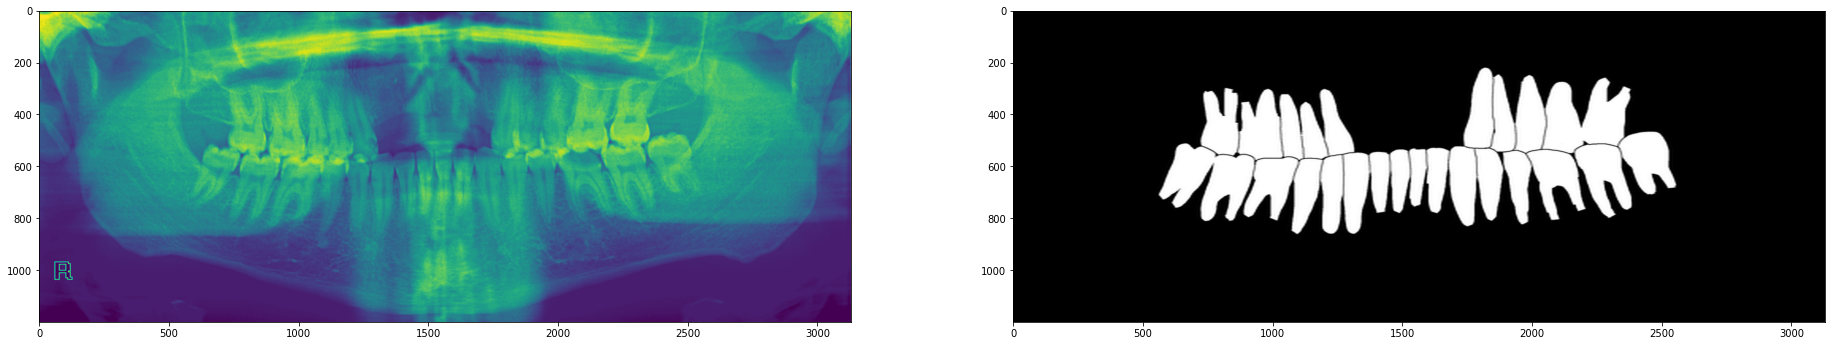

In [86]:
###Pre-Process DATA###
def convert_one_channel(img):
    #some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img

def pre_images(resize_shape,path):
    img=Image.open(path)
    img=img.resize((resize_shape),Image.ANTIALIAS)
    img=convert_one_channel(np.asarray(img))
    cv2.imwrite(path,img)
    return img

def resize(resize_shape,path):
    img=Image.open(path)
    # w,h=np.array(img).shape
    # print(w,h)
      # print(img.size)
    img=img.resize((resize_shape),Image.ANTIALIAS)
    return img

# for index in range(10):
#   pre_images((512,512),os.path.join('/content/d/Images', str(index+1)+'.png'))
ress1=Image.open('/content/data/original_img/1.png') #'/content/d/masked_img/1.png'
ress2=Image.open('/content/data/masked_img/1.png')
img1=ress1.resize((3130,1200), Image.ANTIALIAS)
img2=ress2.resize((3130,1200), Image.ANTIALIAS)

fig = plt.figure(figsize = (32,32))
ax = fig.add_subplot(2, 2, 1) 
plt.imshow(img1)
ax = fig.add_subplot(2, 2, 2) 
plt.imshow(img2)

In [ ]:
# def new(resize_shape,path):
#     img=cv2.imread(path)
#     print(img.shape)
#     # w,h=np.array(img).shape
#     # print(w,h)
# for index in range(10):
#   new((512,512),os.path.join('/content/d/Images', str(index+1)+'.png'))

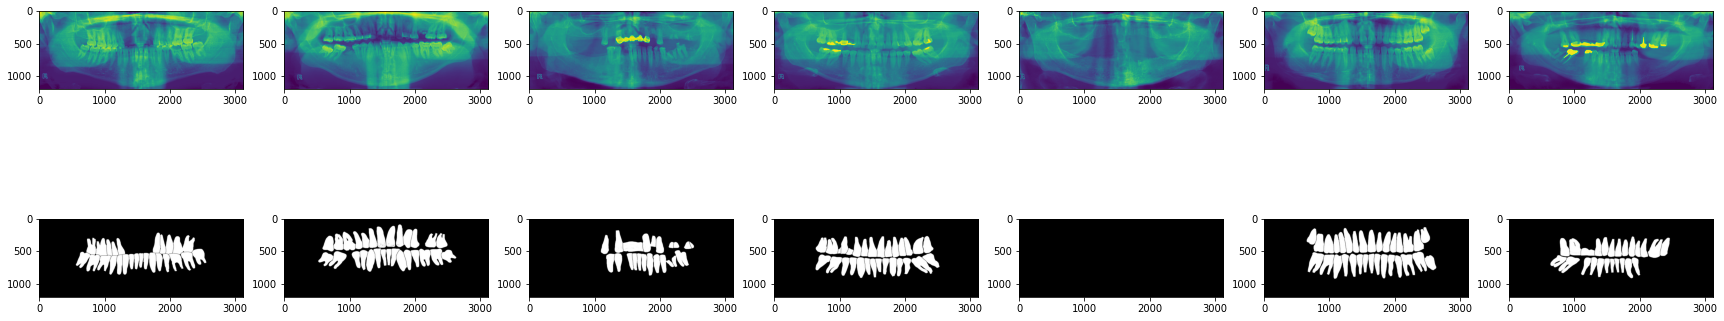

In [87]:
###display some processed result
fig = plt.figure(figsize = (30,7))
for index in range(7):
  file_path1 = os.path.join('/content/data/original_img', str(index+1)+'.png')
  file_path2 = os.path.join('/content/data/masked_img', str(index+1)+'.png')
  # print(file_path2)
  ax = fig.add_subplot(2, 7, index+1) 
  plt.imshow(pre_images((3130,1200),file_path1))  #show result of converting every img to one color channel
  # plt.imshow(cv2.imread(file_path1))
    
  ax = fig.add_subplot(2, 7, index+8)
  plt.imshow(resize((3130,1200),file_path2))
  # plt.imshow(cv2.imread(file_path2))

In [88]:
###generate file names to keep track of file for later usage
arr1=np.arange(1,117)
# print(arr1.dtype)
arr1=arr1.astype(str)
# print(type(arr1))
df=pd.DataFrame(arr1)
df[1]=df[0]
df[0]=df[0]+'.png'
df.to_csv('/content/data/sample.csv',index=False)

In [89]:
###rename all files in masked_img folder
#make sure only run this once
folder='/content/data/masked_img'
for file_name in os.listdir(folder):
    source = folder+'/'+file_name
    # print(source)

    destination = source.replace('.png','_m.png')
    # print(destination)
    # Renaming the file
    os.rename(source, destination)

In [90]:
###move renamed files to orginal_image folder
for file_name in os.listdir(folder):
  source = folder+'/'+file_name
  # print(source)
  destination = '/content/data/original_img/'+file_name
  # # print(destination)
  os.rename(source,destination)

In [91]:
#make sure all pairs a generated
files =  os.listdir('/content/data/original_img')
sorted_files = sorted(files)
print(len(sorted_files))

232


In [92]:
###Load DATA

rest_set_size = 0.3
test_set_size = 0.5
class dset(Dataset):
    def __init__(self, root_dir, train=True,test=True,transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(root_dir, 'sample.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.test = test
        
        # split the dataset to train and rest
        # split the rest to validation and test
        self.train_data, self.rest_data = train_test_split(self.pixel_file, test_size = rest_set_size, random_state = 5)
        self.validation_data, self.test_data = train_test_split(self.rest_data, test_size = test_set_size, random_state = 5)

    def __len__(self):
        if self.train:
          length = len(self.train_data)
        elif self.test:
          length = len(self.test_data)
        else:
          length = len(self.validation_data)
        return length
    
    def __getitem__(self, index):
        if self.train:
          imx_name = os.path.join(self.root_dir, 'original_img',self.train_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.train_data.iloc[index, 0].replace('.png','_m.png'))
        elif self.test:
          imx_name = os.path.join(self.root_dir, 'original_img',self.test_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.test_data.iloc[index, 0].replace('.png','_m.png'))
        else:
          imx_name = os.path.join(self.root_dir, 'original_img', self.validation_data.iloc[index, 0])
          imy_name = os.path.join(self.root_dir, 'original_img',self.validation_data.iloc[index, 0].replace('.png','_m.png'))
        
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')

        ##data augmentation
        if self.train:
          #Random horizontal flipping
          if random.random() > 0.5:
              imx = TF.hflip(imx)
              imy = TF.hflip(imy)

          #Random vertical flipping
          if random.random() > 0.5:
              imx = TF.vflip(imx)
              imy = TF.vflip(imy)

          #Random rotation
          if random.random() > 0.8:
            angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
            imx = TF.rotate(imx, angle)
            imy = TF.rotate(imy, angle)

        if self.transformX:
            imx = self.transformX(imx)
            imy = self.transformY(imy)
      
        sample = {'image': imx, 'annotation': imy}
        return sample

In [93]:
###initialize data_loaders
tx_X = transforms.Compose([ transforms.Resize((1200, 3130)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])
tx_Y = transforms.Compose([ transforms.Resize((1200, 3130)),
                              transforms.ToTensor()
                              ])
train_data = dset('/content/data', train=True, test=False, transformX = tx_X, transformY = tx_Y)
validation_data = dset('/content/data', train=False,test=False,transformX = tx_X, transformY = tx_Y)
test_data = dset('/content/data', train=False, test=True,transformX = tx_X, transformY = tx_Y)

train_loader = DataLoader(dataset=train_data, batch_size=2, shuffle=True, num_workers=2)
validation_loader = DataLoader(dataset=validation_data, batch_size=2, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_data, batch_size=2, shuffle=True, num_workers=2)

In [94]:
print(len(train_data))
print(len(validation_data))
print(len(test_data))

81
17
18


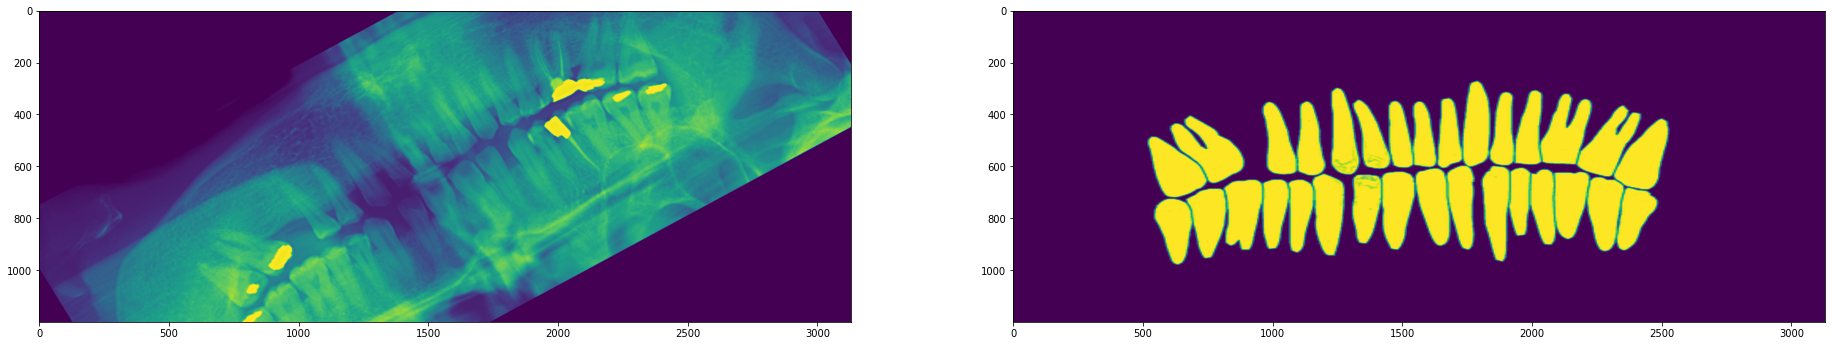

In [95]:
# print(train_data[0]['image'])
# plt.imshow(train_data[0]['image'].squeeze(0))
fig = plt.figure(figsize = (32,32))
ax = fig.add_subplot(2, 2, 1) 
plt.imshow(train_data[2]['image'].squeeze(0))
ax = fig.add_subplot(2, 2, 2) 
plt.imshow(train_data[2]['annotation'].squeeze(0))